### (Cose da sistemare)
#### - Normalizzazione, lascio spazi? Underscore.. per fare il check su nome categoria presente nel nome file
#### - Salvare il dataframe con i dataset esternamente
#### - RandomForest settare bene n tree
#### - Caratteristiche per le categorie.. (ovvio)
#### - Limitare numero features da iterare in dataset..?
#### -
#### - Pulizia clustering, tolgo la variabile categorica in output
#### - Reti neurali semplici classificazione
#### - Tabular classification

---------------------------

In [20]:
#Librerie base (servono sempre/quasi sempre)
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
#Per i json
import json


#sklearn per ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#test normalità
from scipy.stats import shapiro, kstest
#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

In [21]:
import re
def normalize_word(feature):
    # Rimozione di simboli strani e sostituzione degli spazi con underscore
    new_feature = re.sub(r'[^a-zA-Z_]', '', feature)
    # Sostituisci underscore con spazio
    new_feature = new_feature.replace('_', ' ')    
    
    # Inserisci spazio tra lettere maiuscole e minuscole
    new_feature = re.sub(r'([a-z])([A-Z])', r'\1 \2', new_feature)
    #gestisce caso 2 maiuscole
    new_feature = re.sub(r'([A-Z])([A-Z][a-z])', r'\1 \2', new_feature)
    
    # Trasformazione in minuscolo
    new_feature = new_feature.lower()
    #Rimuove eventuali spazi di troppo e iniziali finali
    new_feature = new_feature.strip()
    new_feature = re.sub(r'\s+', ' ', new_feature)
    return new_feature

In [22]:
def is_valid_date(date_string):
    datetime_formats = ['%Y-%m-%d', '%d-%m-%Y', '%m-%d-%Y', '%Y-%d-%m','%m-%Y','%Y-%m',
                    '%Y/%m/%d', '%d/%m/%Y', '%m/%d/%Y', '%Y/%d/%m', '%m/%Y', '%Y/%m',
                       '%H:%M', '%H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    valid = False
    correct_format = None
    for date in datetime_formats:
        try:
            # Prova a convertire la stringa in un oggetto datetime
            datetime.strptime(date_string, date)
            valid = True
            correct_format = date
            break
        except ValueError:
            valid = False
    return valid, correct_format

def dates_to_numbers(date_list, date_format):
    try:
        # Converti ogni data nella lista in un numero
        numbers = [datetime.strptime(date, date_format).strftime('%Y%m%d') for date in date_list]
        return numbers
    except ValueError:
        # Se la conversione fallisce, restituisci un valore di errore
        return None
            
            

def is_sorted(lst):
    return all(lst[i] <= lst[i + 1] for i in range(len(lst) - 1)) or all(lst[i] >= lst[i + 1] for i in range(len(lst) - 1))


## Creazione Dataframe di Dataset

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

def get_classification_properties(feature, index, n_features, categvariable_counter, categpresence):
    #class_names = ['class', 'label', 'target', 'outcome', 'categor']
    class_names = ['label', 'target', 'outcome', 'categor']
    class_name_match = 0 #presenza di una variabile che fa match il nome possibile del label per le categorie
    last_class_name_match = 0 #ultima posizione di questa varibile che fa match, se esiste
    class_name_categorical = 0 #variabile di tipo categorico che fa match

    feature_name_normalized = normalize_word(str(feature['feature_name']))

    if (feature['feature_type'] == 'categorical textual' or feature['feature_type'] == 'categorical numerical'):
        categpresence = 1
        categvariable_counter+=1
    #or feature_name_normalized == 'y'    
    if (any(name in feature_name_normalized for name in class_names) or feature_name_normalized == 'y'):   
        class_name_match = 1
        if (feature['feature_type'] == 'categorical textual' or feature['feature_type'] == 'categorical numerical'):
            class_name_categorical = 1            
        if (index == n_features-1):
            last_class_name_match = 1 
  
    return (class_name_match, last_class_name_match, class_name_categorical, categpresence, categvariable_counter)
        
def get_regression_properties(feature, numvariable_counter, variablenormal_counter):     
    numeric_elements = feature["elements_sampled"]
    #print(numeric_elements)
        #è numerica ma rappresentata in stringhe? converto
    if (pd.api.types.is_numeric_dtype(feature['feature_datatype']) == False):
        numeric_elements = [float(el) for el in numeric_elements]
        
    numvariable_counter+=1

    if(len(numeric_elements)>3):
        stat_shapiro, p_shapiro = shapiro(numeric_elements)
        if (p_shapiro > 0.05):
            variablenormal_counter+=1  
    return (numvariable_counter, variablenormal_counter)

def get_nlp_properties(feature, textual_variables_counter):
    first_element = feature['elements_sampled'][0]
    if(isinstance(first_element,str)): #verifico che è una stringa
        #if (len(first_element) > 35 ):   
        textual_variables_counter+=1
    return textual_variables_counter

def get_clustering_properties(numerical_dataframe):
    silhouette = -1
    if(len(numerical_dataframe[0])>20):
        input_df = list(map(list, zip(*numerical_dataframe)))
        # Normalizza le features
        scaler = StandardScaler()
        features_numeriche_normalizzate = scaler.fit_transform(input_df)
        # Applica K-Means come esempio di algoritmo di clustering
        n_clusters_set = [3,4,5]
        silhouette_results = []
        for n_c in n_clusters_set:
            kmeans = KMeans(n_clusters=n_c, random_state=42)
            clusters = kmeans.fit_predict(features_numeriche_normalizzate)
            silhouette_avg = silhouette_score(features_numeriche_normalizzate, clusters)
            silhouette_results.append(silhouette_avg)
        
        silhouette = np.max(silhouette_results)   
    return silhouette
    
def get_timeseries_properties(feature, date_counter):
    sorted_dates = 0
    valid = is_valid_date(feature['elements_sampled'][0]) 
    #if(valid[0]==True):
    date_counter+=1
    #provo i primi 10
    len_check = 10
    if (len(feature['elements_sampled'])< 10):
        len_check = len(feature['elements_sampled'])
    if (valid[1] is not None):
        converted = dates_to_numbers(feature['elements_sampled'][0:len_check], valid[1])
        if (converted is not None):
            if(is_sorted(converted)):
                sorted_dates = 1
    return date_counter, sorted_dates
                  
        
    
#def get_pca_properties():



#def get_computervision_properties()
    
    

In [24]:
#input: vector of features name
def get_properties(features):
    n_features = len(features)
    #classification
    classification_results = [0,0,0,0,0]
    categvariable_proportion = 0.0
    #regression
    regression_results = [0,0]
    numvariable_proportion = 0.0
    variablenormal_proportion = 0.0
    #textual
    textual_variables_counter = 0
    textual_proportion = 0.0
    #clustering
    numerical_vector = []
    silhouette = -1
    #time series
    time_series_results = [0,0]
    #multiple categories
    average_correlation = 0
    
    label_type = 0 #no label
    
    for index, feature in enumerate(features):  
        #sistema continuous/discrete
        if (feature['feature_type'] == 'categorical numerical'):
            if(len(list(set(feature['elements_sampled'])))>10):
                feature['feature_type'] = 'continuous numerical'
                
        if (index == len(features)-1):
            if(feature['feature_type']=='continuous numerical'):
                label_type = 1
            if( (feature['feature_type']=='categorical numerical') or (feature['feature_type']=='categorical textual')):
                label_type = 2
            
            
        classification_results = get_classification_properties(feature, index, n_features, 
                                                               classification_results[4], classification_results[3])
        #è una data/tempo
        if (feature['feature_type']== 'datetime'):
            time_series_results = get_timeseries_properties(feature, time_series_results[0])
            
        #è testuale
        if (feature['feature_type']== 'text'):
            for i in range(0, len(feature['elements_sampled'])):
                feature['elements_sampled'][i] = str(feature['elements_sampled'][i])#per essere sicuri
                
            textual_variables_counter = get_nlp_properties(feature, textual_variables_counter)
            #time_series_results = get_timeseries_properties(feature, time_series_results[0])
            
        #è numerica        
        if (feature['feature_type'] == 'continuous numerical'):
            #regression
            regression_results = get_regression_properties(feature, regression_results[0], regression_results[1])
            #numerical_vector.append(feature['elements_sampled'])
            
    #df_numerical = pd.DataFrame(numerical_vector)
    #if(len(numerical_vector)>1):
    #    silhouette = get_clustering_properties(numerical_vector)
    #    correlation_matrix = df_numerical.corr()
        
    #    average_correlation = correlation_matrix.mean().mean()
    #    if (np.isnan(average_correlation)):
    #        average_correlation = 0.0

        
        
        
    if (n_features > 0):       
        #quante variabili numeriche ci sono in proporzione sul totale
        numvariable_proportion = regression_results[0]/n_features
        categvariable_proportion = classification_results[4]/n_features
    if (regression_results[0]> 0):          
        #proporzione di variabili con distribuzione normale sul totale variabili numeriche
        variablenormal_proportion = regression_results[1]/regression_results[0]
    if (n_features> 0):
        textual_proportion = textual_variables_counter/n_features
        
    return (classification_results[0],classification_results[1],
            classification_results[2],classification_results[3],classification_results[4], categvariable_proportion, #classification
            regression_results[0], numvariable_proportion, regression_results[1], variablenormal_proportion, #regression
            textual_variables_counter, textual_proportion, #nlp
            silhouette, #clustering
            time_series_results[0], time_series_results[1], #time series
            average_correlation, label_type) 
            
      

In [6]:
#tolgo eventuali dataset testuali da "classification" per non confondere
def classification_filter(file):
    correct_label = 'classification'
    for feature in file['features_content']:
        if (feature['feature_type'] == 'text'):
            if (len(feature['elements_sampled'][0]) > 25): #se la lunghezza dei caratteri supera 25, sono testi
                correct_label = 'nlp'
                break
    return correct_label
                
           

In [7]:
#Creazione Dataset 
cols = ['datapoint_name', #generic
        'dataset_name', #generic
        'n_features', #generic/pca
        'n_instances', #generic
        #'classname_presence','lastcolname_classmatch', 'classname_categorical', 'categorical_presence',
        'categorical_counter','categorical_proportion',#classification
        'numvariable_counter', 'numvariable_proportion', 
        #'variablenormal_counter', 'variablenormal_proportion', #linear_regr 
        'textual_variables_counter', 'textual_proportion', #nlp
        #'silhouette', #clustering
        'date_counter','are_sorted_dates', #time series
        #'average_.l4rcorrelation', #multiple categories
        'label_type',
        'label']
data = pd.DataFrame(columns=cols)

In [8]:
data

,datapoint_name,dataset_name,n_features,n_instances,categorical_counter,categorical_proportion,numvariable_counter,numvariable_proportion,textual_variables_counter,textual_proportion,date_counter,are_sorted_dates,label_type,label


In [9]:
def main_training():
    #Creazione Dataset 
    #cols = ['dataset_name', #generic
    #        'n_features', #generic/pca
    #        'n_instances', #generic
    #        'title_match', #generic
    #        'classname_presence','lastcolname_classmatch', 'classname_categorical', #classification
    #        'numvariable_counter', 'numvariable_proportion', 'variablenormal_counter', 'variablenormal_proportion', #linear_regr 
    #        'textual_variables_counter', 'textual_proportion', #nlp
    #        'silhouette', #clustering
    #        'date_counter','are_sorted_dates', #time series
    #        'label']
    #data = pd.DataFrame(columns=cols)
    
    root_directory = 'datapoints'
    #categories = [dirc for dirc in os.listdir(root_directory)]
    categories = ['classification', 'clustering', 'nlp',  'regression', 'time_series']
    #categories = ['time_series']
    for category in categories:
        directory_path = root_directory + "/" + category + "/"
        datapoints = [datapoint for datapoint in os.listdir(directory_path)]
        for datapoint in datapoints:
            #print(datapoint)
            datapoint_path = directory_path + datapoint
            json_datapoint = {}
            with open(datapoint_path, 'r') as file:
                #try:
                json_datapoint = json.load(file)   
                #except json.JSONDecodeError as e:
                    #print('errore lettura json:')
                    #print(json_datapoint['_id'])
            for file in json_datapoint["files"]:
                #print(json_datapoint['_id'])
                #print(file['file_name'])
                if (file['file_type'] == 'tabular'):  
                    #label corretto
                    label_assigned = json_datapoint['label']
                    if (json_datapoint['label'] == 'classification'):
                        label_assigned = classification_filter(file)

                    #dataset title match with term:category itself
                    filename_normalized = normalize_word(str(file['file_name']))
                    title_match = 0
                    if(category in filename_normalized):
                        title_match = 1

                    result = get_properties(file['features_content']) 
                    if (file['n_istances']>20):
                        data.loc[len(data)] = [json_datapoint['_id'], file['file_name'],
                                               file['n_features'], #all categories
                                               file['n_istances'], #all categories
                                               #title_match, #all categories
                                               #result[0],result[1],result[2], result[3],
                                               result[4],result[5], #classification
                                               result[6],result[7], #linear regression
                                               #result[8],result[9], 
                                               result[10], result[11], #nlp
                                               #result[12], #clustering
                                               result[13],result[14],
                                               #result[15], #pearson
                                               result[16],
                                               label_assigned] #label


        print(category + ' done')


In [10]:
main_training()
#NOISE!

#Clustering con testi/senza numerici non hanno senso e tolgo, poi varabile categorica unica non devo averla
#data = data.drop(data[(data['label']=='clustering') & (data['numvariable_proportion']==0)].index )
#data.loc[ ((data['label']=='clustering') & (data['categorical_counter']==1)), 'categorical_presence'] = 0
#data.loc[ ((data['label']=='clustering') & (data['categorical_counter']==1)), 'categorical_counter'] = 0
#data = data.reset_index(drop=True)

classification done
clustering done
nlp done
regression done
time_series done


In [11]:
data.head()

,datapoint_name,dataset_name,n_features,n_instances,categorical_counter,categorical_proportion,numvariable_counter,numvariable_proportion,textual_variables_counter,textual_proportion,date_counter,are_sorted_dates,label_type,label
0,100-bird-species,birds,5,89885,1,0.200000,1,0.200000,3,0.600000,0,0,0,nlp
1,60k-responses-of-16-personalities-test-mbt,16P,30,59999,29,0.966667,1,0.033333,0,0.000000,0,0,2,classification
2,animal-disease,data,7,871,7,1.000000,0,0.000000,0,0.000000,0,0,2,classification
3,archive (10),classast - pha,12,1748,1,0.083333,11,0.916667,0,0.000000,0,0,2,classification
4,archive (11),dementia_dataset,15,373,7,0.466667,7,0.466667,1,0.066667,0,0,1,classification


In [12]:
#data

In [13]:
#data[data['label']=='clustering']
textdata = pd.read_csv('normalized_data.csv', encoding='latin1')
merged_data = pd.merge(data, textdata, on=['datapoint_name','label'], how='inner')

In [16]:
merged_data.head()

,datapoint_name,dataset_name,n_features,n_instances,categorical_counter,categorical_proportion,numvariable_counter,numvariable_proportion,textual_variables_counter,textual_proportion,date_counter,are_sorted_dates,label_type,label,information
0,animal-disease,data,7,871,7,1.000000,0,0.000000,0,0.0,0,0,2,classification,animal condition classification dataset presen...
1,banking-dataset-classification,new_test,13,8238,10,0.769231,3,0.230769,0,0.0,0,0,2,classification,revenue decline portuguese bank would like kno...
2,banking-dataset-classification,new_train,16,32950,13,0.812500,3,0.187500,0,0.0,0,0,2,classification,revenue decline portuguese bank would like kno...
3,car-acceptability-classification-dataset,car,7,1728,7,1.000000,0,0.000000,0,0.0,0,0,2,classification,car acceptability classification database deri...
4,cervical-cancer-risk-classification,kag_risk_factors_cervical_cancer,30,858,29,0.966667,1,0.033333,0,0.0,0,0,2,classification,cervical cancer risk factors biopsy dataset ob...


In [18]:
#export
merged_data.to_csv('merged_data.csv', index=False)

## Machine Learning

In [25]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [26]:
def n_trees_error(X, y):
    n_estimators_values = range(1, 201, 10)
    # Lista per memorizzare gli errori medi
    mean_errors = []

    for n_est in n_estimators_values:
        model = RandomForestClassifier(n_estimators=n_est, random_state=42)
        errors = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # Puoi scegliere la metrica di valutazione desiderata
        mean_errors.append(np.mean(errors))
        #model.fit(X, y)
        #y_pred = model.predict(X_test)
        #accuracy = accuracy_score(y_test, y_pred)
        #mean_errors.append(accuracy)
    
    plt.figure(figsize=(8, 4))
    plt.plot(n_estimators_values, mean_errors, label='Accuracy Media', marker='o')
    plt.title('Variazione dell\'Errore al Variare di n_estimators')
    plt.xlabel('n_estimators')
    plt.ylabel('Errore')
    plt.legend()
    plt.grid(True)
    plt.show()

In [27]:
def downsample_positives_dataset(dataset, label_column, category):
    #positive_samples = dataset[dataset[label_column] == category]
    positive_samples = dataset[dataset[label_column] == 1]
    #negative_samples = dataset[dataset[label_column] == ('not '+category)] 
    negative_samples = dataset[dataset[label_column] == 0]  
    balanced_positive_samples = resample(negative_samples, 
                                         n_samples=len(positive_samples),
                                         replace=True,random_state=42)    
    dataset_downsampled = pd.concat([balanced_positive_samples, positive_samples]).reset_index(drop=True) 
    return dataset_downsampled

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
#APPROCCIO MULTI
def ml_classifier_multi(input_data, input_cols, model, categories, result):
    c_data = input_data.copy()
    c_data = c_data[c_data['label'].isin(categories)].reset_index(drop=True) 
    
    for i in range(0,len(c_data)):   
        if (c_data['label'][i] == 'classification'):
            c_data.loc[i, 'label'] = 0
        if (c_data['label'][i] == 'regression'):
            c_data.loc[i, 'label'] = 1
        if (c_data['label'][i] == 'clustering'):
            c_data.loc[i, 'label'] = 2
        if (c_data['label'][i] == 'nlp'):
            c_data.loc[i, 'label'] = 3
        if (c_data['label'][i] == 'time_series'):
            c_data.loc[i, 'label'] = 4
    
    
    X = c_data.loc[:, input_cols]
    y = c_data['label'].astype(int)
    
    # Codifica la variabile testuale utilizzando TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Modifica il numero di features secondo necessità
    X_text_tfidf = tfidf_vectorizer.fit_transform(X['information']).toarray()

    # Concatena la rappresentazione numerica e quella testuale
    X_combined = pd.concat([X[input_cols[0:-1]], pd.DataFrame(X_text_tfidf)], axis=1)
    print(X_combined)
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, shuffle=True, random_state=42)
   
    #X_train.to_csv('XY_Data'+ '/' + category +'/' + 'X_train.csv', index=False)
    #X_test.to_csv('XY_Data'+ '/' + category +'/' + 'X_test.csv', index=False)
    #y_train.to_csv('XY_Data'+ '/' + category +'/' + 'y_train.csv', index=False)
    #y_test.to_csv('XY_Data'+ '/' + category +'/' + 'y_test.csv', index=False)
    
    #n_trees_error(X_train, y_train)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f'Accuracy: {accuracy}')
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    
    result['expected'] = y_test
    result['predicted'] = y_pred
    
    
    #CROSS VALIDATION
    # Specifica il numero di fold per la cross-validation
    n_folds = 10  # Puoi regolare questo valore in base alle tue esigenze

    # Inizializza l'oggetto StratifiedKFold
    stratk_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    #cv_results = cross_val_score(model, X, y, cv=stratk_fold, scoring='accuracy')
    #print("Accuracy: %.2f%% (+/- %.2f%%)" % (cv_results.mean() * 100, cv_results.std() * 100))
    y_pred = cross_val_predict(model, X_combined, y, cv=stratk_fold)
    #y_pred = cross_val_predict(model, X, y, cv=stratk_fold)
    # Stampa il classification report
    print(classification_report(y, y_pred))
    
    # Ottieni l'importanza delle features
    #importances = model.feature_importances_
    #indices = np.argsort(importances)[::-1]

    # Stampa l'importanza delle features in ordine
    #print("Importanza delle features:")
    #for f in range(X.shape[1]):
        #print(f"{X.columns[indices[f]]}: {importances[indices[f]]}")


In [37]:
#'dataset_name', #generic
#        'n_features', #generic/pca
#        'n_instances', #generic
#        'title_match', #generic
#        'classname_presence','lastcolname_classmatch', 'classname_categorical', 'categorical_presence',#classification
#        'numvariable_counter', 'numvariable_proportion', 'variablenormal_counter', 'variablenormal_proportion', #linear_regr 
#        'textual_variables_counter', 'textual_proportion', #nlp
#        'silhouette', #clustering
#        'date_counter','are_sorted_dates', #time series
#        'label'

In [15]:
#data.iloc[ind]

In [29]:
result = pd.DataFrame(columns=['expected', 'predicted'])
cols = merged_data.columns[4:-2].append(pd.Index([merged_data.columns[len(merged_data.columns)-1]]))
#cols = merged_data.columns[4:-2]
print(cols)
model = RandomForestClassifier(n_estimators=100, random_state=42)
merged_data['information'].fillna('', inplace=True)
ml_classifier_multi(merged_data, cols, model, ['classification', 'regression', 'nlp', 'clustering', 'time_series'], result)

#0 classification
#1 regression
#2 clustering
#3 nlp
#4 time series

Index(['categorical_counter', 'categorical_proportion', 'numvariable_counter',
       'numvariable_proportion', 'textual_variables_counter',
       'textual_proportion', 'date_counter', 'are_sorted_dates', 'label_type',
       'information'],
      dtype='object')
     categorical_counter  categorical_proportion  numvariable_counter  \
0                      7                1.000000                    0   
1                     10                0.769231                    3   
2                     13                0.812500                    3   
3                      7                1.000000                    0   
4                     29                0.966667                    1   
..                   ...                     ...                  ...   
829                    0                0.000000                    2   
830                    0                0.000000                    1   
831                    1                0.166667                    4   
832  

C:\Users\acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.896414342629482
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84        20
           1       0.83      0.85      0.84        34
           2       0.83      0.72      0.77        40
           3       0.91      0.96      0.94        54
           4       0.93      0.96      0.95       103

    accuracy                           0.90       251
   macro avg       0.88      0.86      0.87       251
weighted avg       0.89      0.90      0.89       251

Confusion Matrix:
 [[16  2  2  0  0]
 [ 1 29  2  0  2]
 [ 1  2 29  3  5]
 [ 0  0  2 52  0]
 [ 0  2  0  2 99]]


C:\Users\acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\acer\anaconda3\lib\site

              precision    recall  f1-score   support

           0       0.88      0.80      0.84        71
           1       0.90      0.79      0.84       108
           2       0.81      0.77      0.79       144
           3       0.88      0.98      0.92       166
           4       0.94      0.97      0.95       345

    accuracy                           0.90       834
   macro avg       0.88      0.86      0.87       834
weighted avg       0.90      0.90      0.90       834



C:\Users\acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
#ind = result[(result['expected']==1) & (result['predicted']==0)].index.tolist()

In [26]:
result['expected']=result['expected'].replace({0: 'classification', 1: 'regression', 2: 'clustering', 
                                               3: 'nlp', 4: 'time_series'})
result['predicted']=result['predicted'].replace({0: 'classification', 1: 'regression', 2: 'clustering', 
                                               3: 'nlp', 4: 'time_series'})
result

,expected,predicted
428,classification,classification
930,regression,clustering
781,nlp,nlp
451,classification,nlp
429,nlp,nlp
...,...,...
462,clustering,clustering
693,nlp,nlp
922,regression,classification
398,classification,classification


In [80]:
ind = result[(result['expected']!='classification') & (result['predicted']=='classification')].index.tolist()
data.iloc[ind]

,datapoint_name,dataset_name,n_features,n_instances,classname_presence,lastcolname_classmatch,classname_categorical,categorical_presence,categorical_counter,categorical_proportion,...,numvariable_proportion,variablenormal_counter,variablenormal_proportion,textual_variables_counter,textual_proportion,silhouette,date_counter,are_sorted_dates,average_correlation,label
277,predict-taxi-fare-with-a-bigquery-ml-forecasting,train,8,209673,0,0,0,1,2,0.250000,...,0.750000,0,0.000000,0,0.0,0.509927,0,0,0.993224,clustering
495,diabetes-dataset,diabetes2,9,768,1,1,1,1,1,0.111111,...,0.888889,0,0.000000,0,0.0,0.201873,0,0,0.676688,regression
398,nlpgettingstarted (2),sample_submission,2,3263,1,1,1,1,1,0.500000,...,0.500000,0,0.000000,0,0.0,-1.000000,0,0,0.000000,nlp
275,predict-taxi-fare-with-a-bigquery-ml-forecasting,train,8,209673,0,0,0,1,2,0.250000,...,0.750000,0,0.000000,0,0.0,0.509927,0,0,0.993224,clustering
549,red-wine-quality-cortez-et-al-2009,winequality-red,12,1599,0,0,0,1,1,0.083333,...,0.916667,1,0.090909,0,0.0,0.184468,0,0,0.909690,regression
265,house-prices-2023,house_prices,9,99499,0,0,0,1,6,0.666667,...,0.333333,0,0.000000,0,0.0,0.380730,0,0,0.699759,clustering
558,regression,advanced,12,1599,0,0,0,1,1,0.083333,...,0.916667,1,0.090909,0,0.0,0.184468,0,0,0.909690,regression
533,openintro-possum,possum,14,104,0,0,0,1,4,0.285714,...,0.714286,6,0.600000,0,0.0,0.259822,0,0,0.867900,regression
296,amazon-employee-reviews,Amazon_Reviews,14,9990,0,0,0,1,14,1.000000,...,0.000000,0,0.000000,0,0.0,-1.000000,0,0,0.000000,nlp
493,crab-age-prediction,CrabAgePrediction,9,3893,0,0,0,1,1,0.111111,...,0.888889,0,0.000000,0,0.0,0.395577,0,0,0.890782,regression


In [81]:
result[(result['expected']!='classification') & (result['predicted']=='classification')]

,expected,predicted
277,clustering,classification
495,regression,classification
398,nlp,classification
275,clustering,classification
549,regression,classification
265,clustering,classification
558,regression,classification
533,regression,classification
296,nlp,classification
493,regression,classification


In [23]:

#One vs All (binary)
def ml_classifier(input_data, input_cols, category, model, other_categories, result):
    c_data = input_data.copy()
    #One vs All
    c_data = c_data[c_data['label'].isin(other_categories)].reset_index(drop=True) 
    for i in range(0,len(c_data)):   
        if (c_data['label'][i] != category):
            c_data.loc[i, 'label'] = 0
        else:
            c_data.loc[i, 'label'] = 1
            
    print('lunghezza totale '+ str(len(c_data[c_data['label']==1])))
    
    #2 Down sampling positivi        
    #c_data_downsampled = downsample_positives_dataset(c_data, 'label', category)
    # Suddividi il dataset in training set e test set (normale + down sampled)
    X = c_data.loc[:, input_cols]
    y = c_data['label'].astype(int)

    #X_down = c_data_downsampled.loc[:, input_cols]
    #y_down = c_data_downsampled['label'].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
    #X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_down, y_down, test_size=0.3, shuffle=True, 
    #                                                                    random_state=42)
   
    X_train.to_csv('XY_Data'+ '/' + category +'/' + 'X_train.csv', index=False)
    X_test.to_csv('XY_Data'+ '/' + category +'/' + 'X_test.csv', index=False)
    y_train.to_csv('XY_Data'+ '/' + category +'/' + 'y_train.csv', index=False)
    y_test.to_csv('XY_Data'+ '/' + category +'/' + 'y_test.csv', index=False)
    #X_train_down.to_csv('XY_Data'+ '/' + category +'/' + 'X_train_down.csv', index=False)
    #X_test_down.to_csv('XY_Data'+ '/' + category +'/' + 'X_test_down.csv', index=False)
    #y_train_down.to_csv('XY_Data'+ '/' + category +'/' + 'y_train_down.csv', index=False)
    #y_test_down.to_csv('XY_Data'+ '/' + category +'/' + 'y_test_down.csv', index=False)
    
    #n_trees_error(X_train, y_train)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f'Accuracy: {accuracy}')
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    
    result['expected'] = y_test
    result['predicted'] = y_pred
    
    
    #CROSS VALIDATION
    # Specifica il numero di fold per la cross-validation
    n_folds = 10  # Puoi regolare questo valore in base alle tue esigenze

    # Inizializza l'oggetto StratifiedKFold
    stratk_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    #cv_results = cross_val_score(model, X, y, cv=stratk_fold, scoring='accuracy')
    #print("Accuracy: %.2f%% (+/- %.2f%%)" % (cv_results.mean() * 100, cv_results.std() * 100))
    y_pred = cross_val_predict(model, X, y, cv=stratk_fold)
    #y_pred = cross_val_predict(model, X, y, cv=stratk_fold)
    # Stampa il classification report
    print(classification_report(y, y_pred))

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_test)

    y_proba = model.predict_proba(X_test)[:, 1]

    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(y_proba, y_encoded)
    calibrated_probas = iso_reg.transform(y_proba)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Non Calibrato')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibrazione Perfetta')
    plt.xlabel('Probabilità Predette')
    plt.ylabel('Frequenza Relativa Positivi')
    plt.title('Curva di Calibrazione Non Calibrato')
    plt.legend()

    plt.subplot(1, 2, 2)
    prob_true_iso, prob_pred_iso = calibration_curve(y_test, calibrated_probas, n_bins=10)
    plt.plot(prob_pred_iso, prob_true_iso, marker='o', linestyle='-', label='Calibrato')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibrazione Perfetta')
    plt.xlabel('Probabilità Predette')
    plt.ylabel('Frequenza Relativa Positivi')
    plt.title('Curva di Calibrazione Calibrato')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Ottieni l'importanza delle features
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Stampa l'importanza delle features in ordine
    print("Importanza delle features:")
    for f in range(X.shape[1]):
        print(f"{X.columns[indices[f]]}: {importances[indices[f]]}")
    
    #y_pr = [1 if prob >= 0.5 else 0 for prob in y_proba]
    #print(y_proba)
    #accuracy = accuracy_score(y_test, y_pr)
    #report = classification_report(y_test, y_pr)
    #conf_matrix = confusion_matrix(y_test, y_pr)
    #print(f'Accuracy: {accuracy}')
    #print("Classification Report:\n", report)
    #print("Confusion Matrix:\n", conf_matrix)


## Classification

lunghezza totale 319
Accuracy: 0.9243902439024391
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       321
           1       0.79      0.89      0.84        89

    accuracy                           0.92       410
   macro avg       0.88      0.91      0.89       410
weighted avg       0.93      0.92      0.93       410

Confusion Matrix:
 [[300  21]
 [ 10  79]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1045
           1       0.82      0.91      0.86       319

    accuracy                           0.93      1364
   macro avg       0.89      0.92      0.91      1364
weighted avg       0.94      0.93      0.93      1364



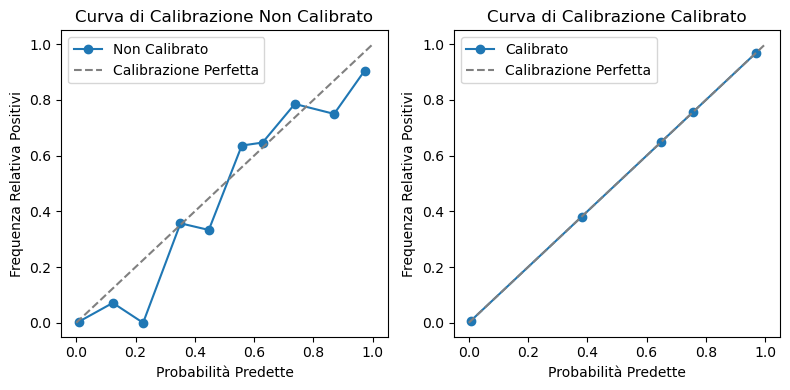

Importanza delle features:
categorical_proportion: 0.26211226698830165
categorical_counter: 0.20015630453527067
numvariable_proportion: 0.15592225049696376
numvariable_counter: 0.15337013262907703
textual_proportion: 0.09782800247693375
date_counter: 0.05848533828989349
textual_variables_counter: 0.05457952587089499
are_sorted_dates: 0.017546178712664676


In [27]:
import xgboost as xgb
#CLASSIFICATION
result = pd.DataFrame(columns=['expected', 'predicted'])
cols = data.columns[4:-1]
#cols = ['classname_presence', 'lastcolname_classmatch', 'classname_categorical',
#       'categorical_presence', 'categorical_counter', 'categorical_proportion',
#       'numvariable_counter', 'numvariable_proportion','silhouette',
#       'variablenormal_counter', 'variablenormal_proportion',
#       'textual_variables_counter', 'textual_proportion', 
#       'date_counter', 'are_sorted_dates', 'average_correlation']

cl_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Definisci il modello XGBoost
#cl_model  = xgb.XGBClassifier(
#    objective='binary:logistic',  # Per problemi di classificazione binaria
#    eval_metric='logloss'          # Metrica di valutazione
#)
#cl_model = LogisticRegression(random_state=42)
#data[data['']]
ml_classifier(data, cols, 'classification', cl_model, 
              ['classification', 'time_series', 'clustering', 'nlp', 'regression'], 
              result)

## Regression

lunghezza totale 136
Accuracy: 0.8853658536585366
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       368
           1       0.33      0.12      0.18        42

    accuracy                           0.89       410
   macro avg       0.62      0.55      0.56       410
weighted avg       0.85      0.89      0.86       410

Confusion Matrix:
 [[358  10]
 [ 37   5]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1228
           1       0.59      0.24      0.34       136

    accuracy                           0.91      1364
   macro avg       0.76      0.61      0.65      1364
weighted avg       0.89      0.91      0.89      1364



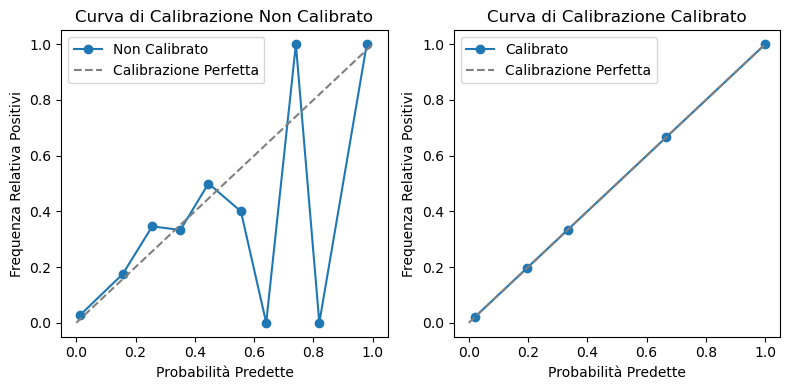

Importanza delle features:
numvariable_counter: 0.23332951371757388
numvariable_proportion: 0.22741466542432826
categorical_proportion: 0.20632944407758141
categorical_counter: 0.13885587287427556
textual_proportion: 0.08961883151691526
textual_variables_counter: 0.04727921426997631
date_counter: 0.03558918301634166
are_sorted_dates: 0.021583275103007723


In [29]:
#REGRESSION
result = pd.DataFrame(columns=['expected', 'predicted'])
cols = data.columns[4:-1]

reg_model = RandomForestClassifier(n_estimators=100, random_state=42)
#reg_model  = xgb.XGBClassifier(
#    objective='binary:logistic',  # Per problemi di classificazione binaria
#    eval_metric='logloss'          # Metrica di valutazione
#)
ml_classifier(data, cols, 'regression', reg_model, ['regression', 'nlp', 'clustering', 'time_series', 'classification'], result)

## NLP

lunghezza totale 305
Accuracy: 0.9243902439024391
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       312
           1       0.82      0.88      0.85        98

    accuracy                           0.92       410
   macro avg       0.89      0.91      0.90       410
weighted avg       0.93      0.92      0.93       410

Confusion Matrix:
 [[293  19]
 [ 12  86]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1059
           1       0.84      0.86      0.85       305

    accuracy                           0.93      1364
   macro avg       0.90      0.91      0.90      1364
weighted avg       0.93      0.93      0.93      1364



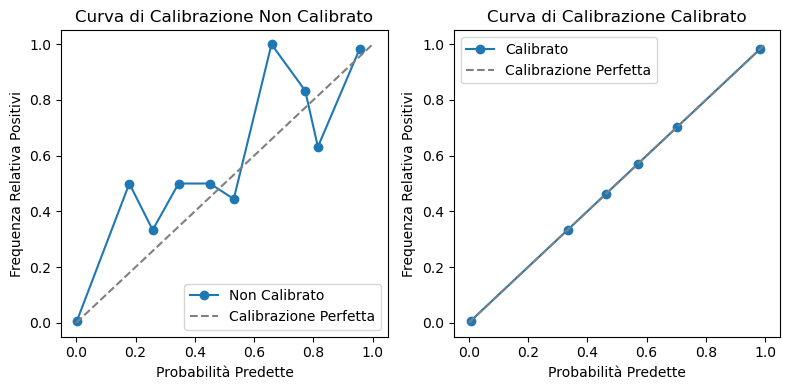

Importanza delle features:
textual_proportion: 0.41053026214241617
textual_variables_counter: 0.22482495536816302
numvariable_counter: 0.09875126413030354
numvariable_proportion: 0.09485547918008391
categorical_proportion: 0.06973882405655847
categorical_counter: 0.06267304996975219
date_counter: 0.027441436066849553
are_sorted_dates: 0.011184729085873217


In [30]:
#NLP
result = pd.DataFrame(columns=['expected', 'predicted'])
cols = data.columns[4:-1]

nlp_model = RandomForestClassifier(n_estimators=100, random_state=42)
ml_classifier(data, cols, 'nlp', nlp_model, ['classification', 'regression', 'nlp', 'clustering', 'time_series'], result)

## Clustering

lunghezza totale 182
Accuracy: 0.8878048780487805
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       350
           1       0.68      0.43      0.53        60

    accuracy                           0.89       410
   macro avg       0.80      0.70      0.73       410
weighted avg       0.88      0.89      0.88       410

Confusion Matrix:
 [[338  12]
 [ 34  26]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1182
           1       0.68      0.42      0.52       182

    accuracy                           0.90      1364
   macro avg       0.80      0.70      0.73      1364
weighted avg       0.88      0.90      0.89      1364



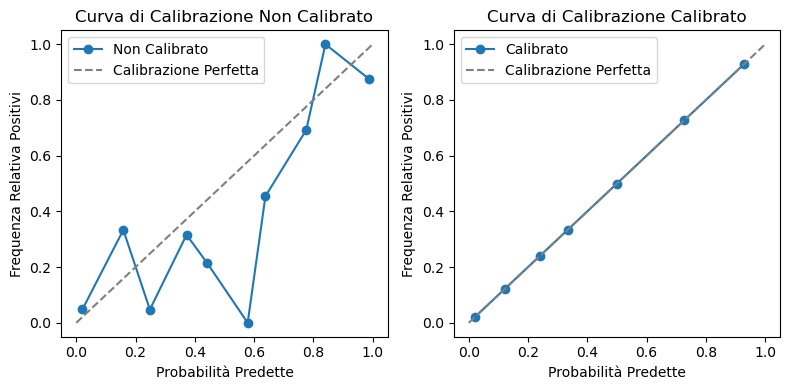

Importanza delle features:
numvariable_counter: 0.24942082565745055
numvariable_proportion: 0.20698878154123412
categorical_proportion: 0.1856190822552886
categorical_counter: 0.14728754728078927
textual_proportion: 0.0962283629294609
textual_variables_counter: 0.06590365866861227
date_counter: 0.036897042696943036
are_sorted_dates: 0.01165469897022127


In [31]:
#CLUSTERING
result = pd.DataFrame(columns=['expected', 'predicted'])
cols = data.columns[4:-1]

clu_model = RandomForestClassifier(n_estimators=100, random_state=42)
#clu_model = xgb.XGBClassifier(
#    objective='binary:logistic',  # Per problemi di classificazione binaria
#    eval_metric='logloss'          # Metrica di valutazione
#)
ml_classifier(data, cols, 'clustering', clu_model, ['classification', 'regression', 'nlp', 'clustering', 'time_series'], result)

## Time Series

lunghezza totale 422
Accuracy: 0.9
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       289
           1       0.84      0.81      0.83       121

    accuracy                           0.90       410
   macro avg       0.88      0.87      0.88       410
weighted avg       0.90      0.90      0.90       410

Confusion Matrix:
 [[271  18]
 [ 23  98]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       942
           1       0.83      0.85      0.84       422

    accuracy                           0.90      1364
   macro avg       0.88      0.89      0.89      1364
weighted avg       0.90      0.90      0.90      1364



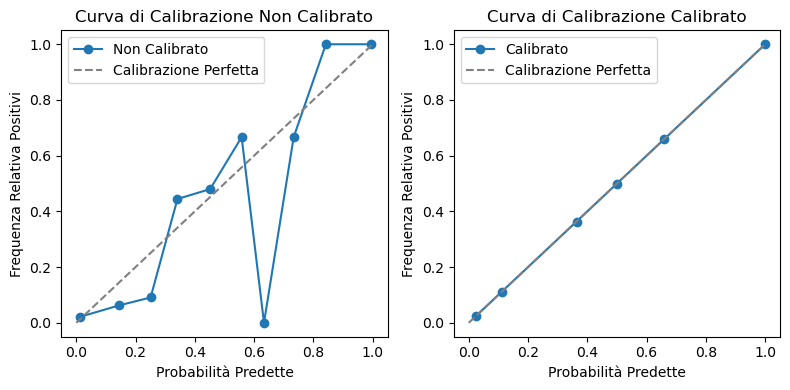

Importanza delle features:
categorical_proportion: 0.23269892804738684
date_counter: 0.18286544537494656
categorical_counter: 0.14374642217243888
numvariable_counter: 0.11493245788580711
textual_proportion: 0.10412338583520706
numvariable_proportion: 0.09070335411927684
textual_variables_counter: 0.0702784712825067
are_sorted_dates: 0.060651535282430086


In [32]:
#TIME SERIES
result = pd.DataFrame(columns=['expected', 'predicted'])
cols = data.columns[4:-1]

ts_model = RandomForestClassifier(n_estimators=100, random_state=42)
ml_classifier(data, cols, 'time_series', ts_model, ['classification', 'regression', 'nlp', 'clustering', 'time_series'], result)

## PCA (NO)

In [108]:
#PCA
#cols = ['n_features', 'n_instances']
#pca_model = RandomForestClassifier(n_estimators=100, random_state=42)
#ml_classifier(data, cols, 'pca', pca_model)

In [162]:
#from sklearn.multioutput import MultiOutputClassifier

#multiclassifier = MultiOutputClassifier(RandomForestClassifier(random_state=42))
#ml_classifier_multi(data, 
#                    ['classname_presence','lastcolname_classmatch', 'classname_categorical', #classification
#                     'numvariable_counter', 'numvariable_proportion', 'variablenormal_counter', 'variablenormal_proportion', #linear_regr 
#                     'textual_variables_counter', 'textual_proportion', #nlp
#                     'silhouette', #clustering
#                     'date_counter','are_sorted_dates',],
#                     multiclassifier)

In [34]:
def main(datapoints_path):  
    #Creazione Dataset 
    #Creazione Dataset 
    cols = ['dataset_name', #generic
        'n_features', #generic/pca
        'n_instances', #generic
        'title_match', #generic
        'classname_presence','lastcolname_classmatch', 'classname_categorical', 'categorical_presence',#classification
        'numvariable_counter', 'numvariable_proportion', 'variablenormal_counter', 'variablenormal_proportion', #linear_regr 
        'textual_variables_counter', 'textual_proportion', #nlp
        'silhouette', #clustering
        'date_counter','are_sorted_dates', #time series
        'average_correlation', #multiple categories
        'label']
    #data = pd.DataFrame(columns=cols)
    
    datapoints = [datapoint for datapoint in os.listdir(datapoints_path)]
    for datapoint in datapoints:
        data = pd.DataFrame(columns=cols)
        #print(datapoint)
        datapoint_path = datapoints_path +'/'+ datapoint
        json_datapoint = {}
        with open(datapoint_path, 'r') as file:
            json_datapoint = json.load(file)       
        for file in json_datapoint["files"]:
                #print(json_datapoint['_id'])
                #print(file['file_name'])
            if (file['file_type'] == 'tabular'):  
                #dataset title match with term:category itself
                filename_normalized = normalize_word(str(file['file_name']))
                title_match = 0
                #if(category in filename_normalized):
                #    title_match = 1

                result = get_properties(file['features_content'])  
                data.loc[len(data)] = [file['file_name'],
                                           file['n_features'], #all categories
                                           file['n_istances'], #all categories
                                           title_match, #all categories
                                           result[0],result[1],result[2], result[3], #classification
                                           result[4],result[5],result[6],result[7], #linear regression
                                           result[8], result[9], #nlp
                                           result[10],
                                           result[11],result[12],
                                           result[13], #pearson
                                           None] #label
        print()
        print(json_datapoint['_id'])  
        if (len(json_datapoint["files"])>0):
            #print(data)
            results = []
            #Classification
            cols_test = data.columns[4:-1]
            X = data.loc[:, cols_test]
            results.append(cl_model.predict_proba(X)[:, 1][0])
            #Regression
            results.append(reg_model.predict_proba(X)[:, 1][0])
            #Clustering
            results.append(clu_model.predict_proba(X)[:, 1][0])
            #NLP
            results.append(nlp_model.predict_proba(X)[:, 1][0])
            #Time series
            results.append(ts_model.predict_proba(X)[:, 1][0])

            print('Classification:'+ str(results[0]))
            print('Linear Regression:'+ str(results[1]))
            print('Clustering probability:'+ str(results[2]))
            print('NLP probability:'+ str(results[3]))
            print('Time series probability:'+ str(results[4]))





In [35]:
main('output_datasets')


2005-2011-graduation-outcomes-school-level-ell-1
Classification:0.5862945592526758
Linear Regression:0.1616066253285586
Clustering probability:0.34779822646456743
NLP probability:0.08138148099942516
Time series probability:0.025392282597853737

2006-2012-math-test-results-all-students-1
Classification:0.034666666666666665
Linear Regression:0.01
Clustering probability:0.0
NLP probability:0.0
Time series probability:0.955

2006-2012-school-demographics-and-accountability-snapshot-1
Classification:0.07
Linear Regression:0.24033333333333334
Clustering probability:0.4555238095238095
NLP probability:0.0
Time series probability:0.06

2018-2019-daily-attendance-1
Classification:0.11
Linear Regression:0.07585714285714286
Clustering probability:0.8023769841269842
NLP probability:0.01
Time series probability:0.02

Acoustic Features
Classification:0.4
Linear Regression:0.26
Clustering probability:0.3105
NLP probability:0.0
Time series probability:0.23

all-japanese-anime-titles-in-imdb
Classifica


summer
Classification:0.5862945592526758
Linear Regression:0.1616066253285586
Clustering probability:0.34779822646456743
NLP probability:0.08138148099942516
Time series probability:0.025392282597853737

symptom_Description
Classification:0.0
Linear Regression:0.0
Clustering probability:0.0
NLP probability:1.0
Time series probability:0.0

tcc_ceds_music
Classification:0.06
Linear Regression:0.03
Clustering probability:0.225
NLP probability:0.38
Time series probability:0.46

team
Classification:0.5862945592526758
Linear Regression:0.1616066253285586
Clustering probability:0.34779822646456743
NLP probability:0.08138148099942516
Time series probability:0.025392282597853737

tiktok
Classification:0.0
Linear Regression:0.023595238095238093
Clustering probability:0.1716666666666667
NLP probability:0.8582142857142858
Time series probability:0.0

top50
Classification:0.17
Linear Regression:0.4053333333333333
Clustering probability:0.2873333333333333
NLP probability:0.0
Time series probability:

In [ ]:
#ALTRO (TEST..)

In [ ]:
from scipy.stats import shapiro, kstest
import numpy as np

datan = np.random.normal(size=100)  # Sostituisci con il tuo vettore di dati
datan = [1,2,3,np.nan]
stat_shapiro, p_shapiro = shapiro(datan)
stat_kstest, p_kstest = kstest(datan, 'norm')

print(f'Shapiro-Wilk Test: Statistica={stat_shapiro}, p-value={p_shapiro}')
print(f'Kolmogorov-Smirnov Test: Statistica={stat_kstest}, p-value={p_kstest}')